<div style="text-align: right" align="right"><i>Peter Norvig, December 2025</i></div>

# Advent of Code 2025

I  enjoy doing the [**Advent of Code**](https://adventofcode.com/) (AoC) programming puzzles, so here we go for 2025!  

This year I will be doing something different: I will solve each problem myself here, and then [**in another notebook**](Advent-2025-AI.ipynb) I will ask an **AI Large Language Model** to solve the same problem. Check out the differences!

# Day 0

I start by loading up my [**AdventUtils.ipynb**](AdventUtils.ipynb) notebook (same as last time except for the `current_year`). On each day I will first parse the input (with the help of my `parse` utility function, which also prints the first few lines of the input and the resulting parsed data objects), then solve Part 1 and Part 2 (recording the correct answer with my `answer` function).

In [1]:
%run AdventUtils.ipynb
current_year = 2025

I'm thankful that [@GaryGrady](https://mastodon.social/@garygrady) is providing cartoons:

<a href="https://mastodon.social/@garygrady"><img src="https://pbs.twimg.com/media/Gdp709FW8AAq2_m?format=jpg&name=medium" width=500 alt="Gary Grady cartoon"></a>

# [Day 1](https://adventofcode.com/2025/day/1): Secret Entrance

On Day 1 we meet an elf and learn that our task is to finish decorating the North Pole by December 12th. There will be 24 challenges along the way; the first one involves unlocking a safe. The safe has a dial with 100 numbers, and an arrow that currently points at 50. Our input for today is a sequence of left and right rotations; for example "R20" means move the dial right by 20 numbers and "L13" means move it left by 13 numbers. 

I'll use my `parse` utility function to parse each line of the input as an integer, after replacing each 'L' with a minus sign and each 'R' with a plus sign. 

In [2]:
def parse_rotation(line: str) -> str: return int(line.replace('L', '-').replace('R', '+'))

rotations = parse(day=1, parser=parse_rotation) 

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 4780 strs of size 2 to 4:
────────────────────────────────────────────────────────────────────────────────────────────────────
L20
L13
L16
L16
L29
L7
L48
L48
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 4780 ints in range -999 to 997:
────────────────────────────────────────────────────────────────────────────────────────────────────
-20
-13
-16
-16
-29
-7
-48
-48
...


Note that my `parse` function prints the first few input lines, then prints the parsed representation of these lines. That helps me debug and helps you the reader understand what is going on.

<img src="https://files.mastodon.social/media_attachments/files/115/646/343/679/448/846/original/428b312ca88f62c4.jpg" width=500 alt="Gary Grady cartoon">

### Part 1: How many times is the dial left pointing at 0 after any rotation in the sequence?

When applying the rotations in order, we are asked how many of the rotations leave the dial pointing at 0. The `itertools.accumulate` function yields running totals of its input sequence, so we just have to count (quantify) how many times the running total of the rotations is 0 mod 100. I'll write a function to do that and run it on the input:

In [3]:
def count_zeros(numbers, dial=100) -> int:
    """How many zeros (modulo `dial`) in the running partial sums of the numbers?"""
    return quantify(total % dial == 0 for total in accumulate(numbers, initial=50))

In [4]:
count_zeros(rotations)

1182

I submitted "1182" to AoC and got back *That's the right answer!*, so I record the answer (and its run time) like this:

In [5]:
answer(puzzle=1.1, solution=1182, code=lambda: 
       count_zeros(rotations))

Puzzle  1.1:   .0006 seconds, answer 1182            correct

### Part 2: How many times does the dial point to 0 at any time?

For Part 2 we are asked to count both when a rotation ends up at 0 and when the arrow passes 0 at any time during a rotation. For example, if the arrow points to 95, then only a "R5" or a "L95" would register a 0 in Part 1, but now for Part 2 a rotation of "R10" would also count because it passes 0 (as would any rotation of "R5" or larger, or "L95" or larger). 

I'll start with a brute force approach: treat a rotation of, say, 20 as 20 rotations of 1, and then use the same `count_zeros` function from Part 1. (Note that `sign(r)` returns +1 for any positive input, and -1 for any negative input.)

In [6]:
answer(1.2, 6907, lambda:
       count_zeros(sign(r) for r in rotations for _ in range(abs(r))))

Puzzle  1.2:   .1639 seconds, answer 6907            correct

That's a long run time for a Day 1 problem, so here's a faster method: break each rotation down into a number of full circles and some remainder, then add the full circles to the count of zeros, and add one more if the remainder is at least as much as the distance to zero (in the appropriate direction): 

In [7]:
def zero_clicks(rotations, position=50, dial=100) -> int:
    """How many times does any click cause the dial to point at 0?
    Count 1 if the rotation crosses the distance to 0,
    and for large rotations, count abs(r) // 100 more."""
    zeros = 0
    for r in rotations:
        full_circles, remainder = divmod(abs(r), dial)
        distance_to_0 = (dial - position if (r > 0 or position == 0) else position)
        zeros += full_circles + (1 if remainder >= distance_to_0 else 0)
        position = (position + r) % dial
    return zeros

In [8]:
answer(1.2, 6907, lambda:
       zero_clicks(rotations))

Puzzle  1.2:   .0013 seconds, answer 6907            correct

That's much faster, but the code is trickier, and indeed I initially had a **bug** in the `distance_to_0` computation: when the current position is 0 the distance should be 100: it takes a full rotation to get back to 0. I fixed the bug by adding `or position == 0`.

# [Day 2](https://adventofcode.com/2025/day/2): Gift Shop

We're in the North Pole gift shop, where the elves are doing inventory control. Today's input is a list of ranges of product IDs of items in stock. Each range is a pair of integers separated by a dash, and the ranges are separated by commas:

In [9]:
id_ranges = parse(day=2, parser=positive_ints, sections=lambda text: text.split(','))

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 1 str of size 511:
────────────────────────────────────────────────────────────────────────────────────────────────────
990244-1009337,5518069-5608946,34273134-34397466,3636295061-3636388848,8613701-8663602,573252-68 ...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 35 tuples of size 2:
────────────────────────────────────────────────────────────────────────────────────────────────────
(990244, 1009337)
(5518069, 5608946)
(34273134, 34397466)
(3636295061, 3636388848)
(8613701, 8663602)
(573252, 688417)
(472288, 533253)
(960590, 988421)
...


<img src="https://files.mastodon.social/media_attachments/files/115/652/152/368/251/243/original/56e4ed8e5f24db96.jpg" width=500 alt="GaryJGrady cartoon">

### Part 1: What is the sum of the invalid IDs?

An invalid ID is defined as one that consists of a digit sequence repeated twice. So 55, 6464 and 123123 are invalid. We're asked for the sum of the invalid IDs across all the ID ranges.

We could look at every number in every range and check if the first half of the number (as a string) is the same as the second half. How many checks would that be?

In [10]:
sum((hi - lo + 1) for lo, hi in id_ranges)

1990936

Only 2 million! So it would indeed be feasible to check every one. But I have a suspicion that Part 2 would make it infeasible, so I'll invest in a more efficient approach. For each ID range, instead of enumerating every number in the range and checking each one for validity, I will instead enumerate over the *first half* of the possible digit strings in the range, and automatically generate invalid IDs by appending a copy of the first half to itself. By *first half* I don't mean divide by 2; I mean the first half of the digit string: the first half of "123456" is "123".

Suppose the range is 123456-223000.  I enumerate from 123 to 223, and for each number generate an invalid ID:
[123123, 124124, 125125, ... 223223]. I then yield the IDs that are within the range (in this case all but the first and the last are in the range 123456-223000). Altogether I only have to consider 101 half IDs rather than 100,001 full IDs. (The algorithm scales with the square root of the size of the range, not with the size of the range itself.)

In [11]:
def invalids_in_range(lo: int, hi: int) -> Iterable[int]:
    """Yield all the invalid IDs between lo and hi inclusive.
    An ID is invalid if it consists of a digit sequence repeated twice."""
    first_half = str(lo)[:max(1, len(str(lo)) // 2)]
    for i in count_from(int(first_half)):
        id = int(str(i) * 2)
        if lo <= id <= hi:
            yield id
        elif id > hi:
            return

def invalids(id_ranges) -> Set[int]:
    """Invalid IDs, according to any one of the list of invalid ID ranges."""
    return union(invalids_in_range(lo, hi)
                 for (lo, hi) in id_ranges)

assert invalids([(11, 22)]) == {11, 22}

In [12]:
answer(2.1, 23560874270, lambda:
       sum(invalids(id_ranges)))

Puzzle  2.1:   .0030 seconds, answer 23560874270     correct

### Part 2: What is the sum of the invalid IDs, under the new rules?

In Part 2 we discover that an ID should be considered invalid if it consists of two *or more* repeats of a sequence of digits. So 100100 is still invalid, but so are 100100100 and 100100100100 I'll rewrite `invalids_in_range` to take an optional argument saying how many repeats we're looking for, and introduce `all_invalids` to try all possible repeat lengths across all ID ranges:

In [13]:
def invalids_in_range(lo: int, hi: int, repeat=2) -> Iterable[int]:
    """Yield all the invalid IDs between lo and hi inclusive
    that are formed from exactly `repeat` repeated digit sequences."""
    first_half = int(str(lo)[:len(str(lo)) // repeat] or 1)
    for i in count_from(int(first_half)):
        id = int(str(i) * repeat)
        if lo <= id <= hi:
            yield id
        elif id > hi:
            return

def all_invalids(id_ranges) -> Set[int]:
    """All Invalid IDs, according to the list of ranges, with any number of repeats."""
    return union(invalids_in_range(lo, hi, repeat)
                 for (lo, hi) in id_ranges
                 for repeat in range(2, len(str(hi)) + 1))

Since this is a bit tricky, I include some unit test assertions:

In [14]:
assert list(invalids_in_range(2121212118, 2121212124, 5)) == [2121212121]
assert all_invalids([(11, 22), (95, 115)]) == {11, 22, 99, 111}

Now I'll verify that the answer for Part 1 still works, and go ahead and compute the answer for Part 2:

In [15]:
answer(2.1, 23560874270, lambda:
       sum(invalids(id_ranges)))

Puzzle  2.1:   .0039 seconds, answer 23560874270     correct

In [16]:
answer(2.2, 44143124633, lambda:
       sum(all_invalids(id_ranges)))

Puzzle  2.2:   .0039 seconds, answer 44143124633     correct

I initially had another **bug** here: I initially counted "222222" three times: as 2 repeats of "222", or 3 repeats of "22", or 6 repeats of "2". I changed the output of `all_invalids` to be a `set` rather than a `list` to fix that.

# [Day 3](https://adventofcode.com/2025/day/3): Lobby

Entering the lobby, we find that the elevators are offline. We might be able to fix the problem by turning on some batteries. There are multiple battery banks, each bank consisting of a sequence of digits representing the *joltage* level of a battery. 

In [17]:
banks = parse(day=3)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 200 strs of size 100:
────────────────────────────────────────────────────────────────────────────────────────────────────
5353323523322232362334333433323333353233331313222372133133353643423323233323333534414523333432223242
6344544745655555456556556566665564538465555575558846455665837545764555554465564547547565544657585435
2246273372253242254243532252231242225522622633532222322234255122531222423531343223123232234213323424
6545643634344444495734739454433454439454355654483544243344534445434437426443854344454534654439534424
2356636643143433535443636338231745346538433576334436353176353333433532345344334224435234343644332536
3221311221443323323322222214632342232233222322333436263122265162212321261323142262212332322125216222
3336332333336335335324359336493238433441666379243536334165623214253384333323893933867663434332383763
323532125233243133222323243622253243222622322221323343

### Part 1: What is the maximum possible total output joltage?

We can turn on exactly two batteries in each bank, resulting in a two digit number which is the *joltage* of the bank. For example, given the bank "8647" we could choose to turn on the "8" and "7" to produce a joltage of 87; that's the maximum.  We are asked what is the sum of the maximal possible joltage from each bank. The function `total_joltage` computes that; it calls `joltage` on each bank, and `joltage` chooses the biggest first digit, and then the biggest second digit that follows the first digit. Note that the possible choices for the first digit exclude the last digit, because if we chose that, then there would be no choices left for the second digit. (I chose to do the string-to-int conversion in `total_joltage`; it would also be okay to have `joltage` return an int.)

In [18]:
def joltage(bank: str) -> str:
    """The maximum possible joltage by turning on 2 batteries in the bank.
    Pick the biggest first digit, then the biggest digit that follows."""
    first  = max(bank[:-1]) # The first digit can't be the last character
    second = max(bank[bank.index(first) + 1:]) # The second digit must come after the first
    return first + second

def total_joltage(banks: List[str]) -> int:
    """The maximum possible joltage from all the banks."""
    return sum(int(joltage(bank)) for bank in banks)

In [19]:
assert joltage("8647") == "87"
assert joltage("1119") == "19"

In [20]:
answer(3.1, 17085, lambda:
       total_joltage(banks))

Puzzle  3.1:   .0007 seconds, answer 17085           correct

### Part 2: What is the new maximum possible total output joltage?

The elf hits the ***safety override*** button, and we can now turn on 12 batteries per bank, resulting in a 12-digit joltage. What is the new maximum possible total joltage?

I will make a change to the two functions, passing in the number of digits to be chosen, *n* (with default 2 for backwards compatibility). The function `joltage` recurses when there is more than one digit remaining, choosing the first digit from the bank up to the last *n* - 1 characters, then recursively finding the biggest joltage from the rest. 

In [21]:
def joltage(bank: str, n=2) -> str:
    """The maximum possible joltage by turning on `n` batteries in the bank.
    Pick the first digit, then the maximum joltage from the rest of the bank."""
    if n == 1:
        return max(bank)
    else:
        first = max(bank[:-(n - 1)]) # The first digit can't be the last n-1 characters
        rest  = bank[bank.index(first) + 1:]
        return first + joltage(rest, n - 1)

def total_joltage(banks: List[str], n=2) -> int:
    """The maximum possible joltage from all the banks,
    when `n` batteries are turned on per bank."""
    return sum(int(joltage(bank, n)) for bank in banks)

In [22]:
assert joltage("811111111111119", 2)  == '89'
assert joltage("818181911112111", 5)  == '92111'
assert joltage("818181911112111", 12) == '888911112111'

I'll make sure Part 1 still works, and then solve Part 2:

In [23]:
answer(3.1, 17085, lambda:
       total_joltage(banks))

Puzzle  3.1:   .0007 seconds, answer 17085           correct

In [24]:
answer(3.2, 169408143086082, lambda:
       total_joltage(banks, 12))

Puzzle  3.2:   .0020 seconds, answer 169408143086082 correct

# [Day 4](https://adventofcode.com/2025/day/4): Printing Department

The floor of the printing department is divided into squares, some of which contain a roll of paper. The day's input is a map of the floor, with `@` representing a roll of paper. I can handle that with the `Grid` class from my [AdventUtils](AdventUtils.ipynb):

In [25]:
paper_grid = Grid(parse(day=4), directions=directions8)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 140 strs of size 140:
────────────────────────────────────────────────────────────────────────────────────────────────────
.@@@@@...@.@@@@@@@@@@.@@@@@@@.@.@.@@@@@@@@@@@@@..@.@@@.@@@@@@..@.@..@.@@...@.@@@@..@@@@....@@@.@ ...
.@@@@@.@....@.....@@@.@@.@@.@@@.@@@.@.@.@.@@@@@.@@.@@@@@.@@@@@@@@@@@..@@.@.@@.@@@.@@@@@@@@@@@..@ ...
@.@@@@.@@@@.@@@@..@@.@@@@@@@@.@@@@.@@@@.@@..@.@...@.@.@.@.@@..@@@@@.@.@.@@@@.@@@@@@@@@.@@@@..@@. ...
.@.....@.@@@..@.@@@.@..@@@@@..@@@.@@..@...@.@@@@.@@@.@.@@@@@@.@.@@@@@@@.@.@@@.@@@@@@...@@.@@..@. ...
@@@@@.@@@.@@@@@@@..@@.@.@@@..@@..@@@.@@....@.@..@@@@@@@@.@.@@..@@...@@.@@@...@.@.@@@..@.@.@@@@@@ ...
@.@@@@@@..@@@@...@..@@@@@@.@@@..@.....@@.@.@@...@@@.@@.@.@@@....@@.@.@.@@@@.@@@@@.@@@.@@...@@.@@ ...
.@@@.@.@@@..@@.@.@@@@@.@.@..@@....@..@.@.@@@@.@..@@.@..@@@@@.@@@@@@@.@.@@@.@.@@@.@@@@.@@@@@@@@.@ ...
@@@@@@@.@@...@@@....@.@@@@.@@@@@@@@@.@@@.@@.@@..@...@@

<img src="https://files.mastodon.social/media_attachments/files/115/663/375/845/834/867/original/4d3180e12fa726fe.jpg" width=500 alt="Gary Grady cartoon">


### Part 1: How many rolls of paper can be accessed by a forklift?

A roll is **accessible** by forklift if there are fewer than four rolls of paper in the eight adjacent positions (that's why I specified `directions8` in defining `paper_grid`). Counting the number of accessible rolls is easy, but I decided to make `accessible rolls` return a list of positions rather than a count, in anticipation of Part 2.

In [26]:
def accessible_rolls(grid: Grid) -> List[Point]:
    """The positions of all the accessible rolls of paper on the grid."""
    return [p for p in grid if is_accessible(p, grid)]

def is_accessible(p: Point, grid: Grid) -> bool:
    """A roll of paper is accessible if there are fewer than 
    four rolls of paper in the eight adjacent positions."""
    return grid[p] == '@' and grid.neighbor_contents(p).count('@') < 4

Here's the answer:

In [27]:
answer(4.1, 1569, lambda:
       len(accessible_rolls(paper_grid)))

Puzzle  4.1:   .0610 seconds, answer 1569            correct

### Part 2: How many rolls of paper can be removed?

If a paper roll is accessible, it can be removed by forklift. That may in turn make other rolls accessible, and hence removable. How many rolls in total can be removed?

It looks like I was right to make `accessible_rolls` return a list of points rather than a count! I can answer the question by repeatedly finding the accessible rolls, removing them (on a copy of the grid so I don't mess up the original grid), and repeating until there are no more accessible rolls.

In [28]:
def removable_rolls(grid: Grid) -> Iterable[Point]:
    """The positions of paper rolls that can be removed, in any nuber of iterations."""
    grid2 = grid.copy() # To avoid mutating the original input grid
    points = accessible_rolls(grid2)
    while points:
        yield from points
        grid2.update({p: '.' for p in points})
        points = accessible_rolls(grid2)

In [29]:
answer(4.2, 9280, lambda:
       quantify(removable_rolls(paper_grid)))     

Puzzle  4.2:  1.3428 seconds, answer 9280            correct

That's the right answer, but the run time is a bit slow. The main issue is that `accessible_rolls` has to look at the whole grid on every iteration. But if the previous iteration only removed one roll, all we really need to look at on the next iteration is the neighbors of the removed roll. So I'll keep a queue of possibly removable points and repeatedly pop a point off the queue, and if it is an accessible roll, remove it and put all its neighbors on the queue. When the queue is empty, no more rolls can be removed.

In [30]:
def removable_rolls(grid: Grid) -> Iterable[Point]:
    """The positions of paper rolls that can be removed, in any number of iterations."""
    grid2 = grid.copy()   # To avoid mutating the original input grid
    Q = grid.findall('@') # A queue of possibly removable positions in the grid
    while Q:
        p = Q.pop()
        if is_accessible(p, grid2):
            yield p
            grid2[p] = '.'
            Q.extend(grid2.neighbors(p))

In [31]:
answer(4.2, 9280, lambda:
       quantify(removable_rolls(paper_grid)))

Puzzle  4.2:   .1437 seconds, answer 9280            correct

That's almost 10 times faster!

Let's visualize the paper rolls before and after removal:

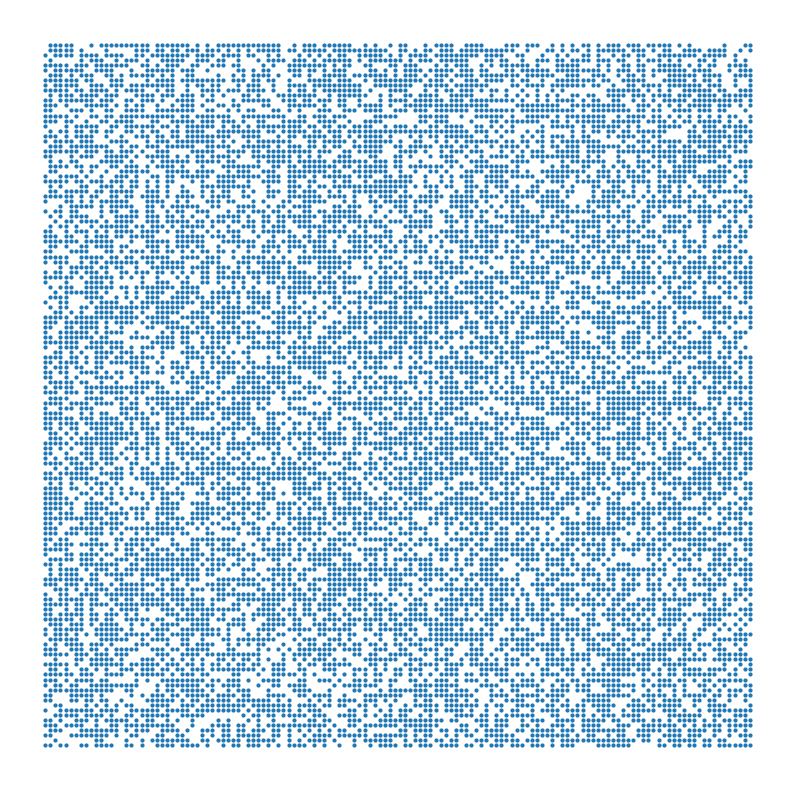

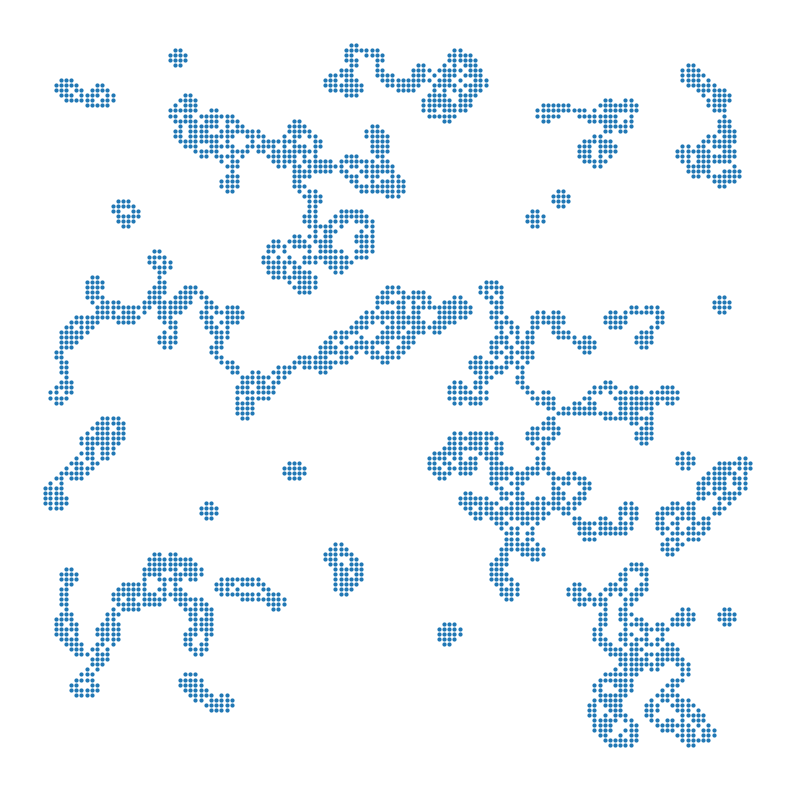

In [32]:
before = set(paper_grid.findall('@'))
after  = before - set(removable_rolls(paper_grid))

naked_plot(before, 'o', markersize=2)
naked_plot(after,  'o', markersize=2)

# [Day 5](https://adventofcode.com/2025/day/5): Cafeteria

Today we're in the cafeteria, and the elves need to figure out which of their ingredients are fresh or spoiled. The input file has two parts (paragraphs), the first consisting of ranges of fresh ingredient IDs, like "6-7" and the second consisting of the available ingredient IDs, like "8". I can parse the data like this:

In [33]:
def parse_ingredients(text: str) -> tuple:
    """Parse either ranges like "3-5", or integers like "8"."""
    if '-' in text:
        return mapt(positive_ints, lines(text))
    return mapt(positive_ints, lines(text)) if '-' in text else ints(text)
                                                   
fresh_ranges, available_ingredient_ids = parse(day=5, parser=parse_ingredients, sections=paragraphs)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 1184 strs of size 0 to 31:
────────────────────────────────────────────────────────────────────────────────────────────────────
292632986393425-296797126337251
428261559408337-431275643240865
197704206528056-198822557342819
36791726875734-37049023408764
134880223152389-139959748438608
31870818340663-32138457068292
443613579514078-447616030778273
284142407577672-288117756872436
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 2 tuples of size 183 to 1000:
────────────────────────────────────────────────────────────────────────────────────────────────────
((292632986393425, 296797126337251), (428261559408337, 431275643240865), (197704206528056, 19882 ...
(92087202605588, 314304587960778, 19184152482180, 331502336245673, 104093299503920, 224082459481 ...


### Part 1: How many of the available ingredient IDs are fresh?

Keep it simple: For each ingredient ID, check to see if it is contained in any of the ranges (then we'll see if this is fast enough):

In [34]:
def count_fresh_ingredients(fresh_ranges, available_ingredient_ids) -> int:
    """How many of the available ingredient IDs are in one of the fresh ranges?"""
    return quantify(any(lo <= id <= hi for (lo, hi) in fresh_ranges)
                    for id in available_ingredient_ids)

In [35]:
answer(5.1, 635, lambda:
       count_fresh_ingredients(fresh_ranges, available_ingredient_ids))

Puzzle  5.1:   .0118 seconds, answer 635             correct

Fast enough! Let's move on.

### Part 2: How many ingredient IDs are fresh?

In Part 2 we are asked how many of the possible ingredient IDs are fresh, regardless of whether the ID is available or not. I could convert a range like "3-5" into the set {3, 4, 5} and then union the sets together. How many elements would be in that set? Here's an estimate: 

In [36]:
sum(hi - lo for (lo, hi) in fresh_ranges)

476036797138761

OK, switch to Plan B. Instead of explicitly building this set I can instead sort the fresh ID ranges (by their low number) and go through them, keeping track of the lowest ID that has not yet been explored for freshness, and a count of the fresh IDs found so far. For each range, the number of new fresh IDs is the length of the range that starts with either the start of the range or the first unexplored ID, and ends at the end of the range.

In [37]:
def count_fresh_ids(fresh_ranges) -> int:
    """How many IDs are contained in the union of the ranges?"""
    fresh_count = 0 # The number of fresh IDs found so far
    unexplored  = 0 # The highest ID number that we haven't considered yet
    for (lo, hi) in sorted(fresh_ranges):
        start = max(unexplored, lo)
        fresh_count += len(range(start, hi + 1))
        unexplored = max(unexplored, hi + 1)
    return fresh_count

In [38]:
answer(5.2, 369761800782619, lambda:
       count_fresh_ids(fresh_ranges))

Puzzle  5.2:   .0002 seconds, answer 369761800782619 correct

# [Day 6](https://adventofcode.com/2025/day/5): Trash Compactor

Trash Compactor? [I've got a bad feeling  about this!](https://youtu.be/CZgeYSqUeTA?si=5UPS_HiCOmTKrEWX&t=32) We've fallen into a garbage smasher and have been asked to help some of the resident cephalopod children with their math homework. We can parse the homework worksheet, but we were told that the exact alignment of columns matters, so I'll keep each line as a string rather than converting it to a list of ints.

<img src="https://files.mastodon.social/media_attachments/files/115/674/362/938/836/432/original/3b83547aa749a914.jpg" width=500 alt="Gary Grady cartoon">

In [39]:
worksheet = parse(6, str)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 5 strs of size 3732:
────────────────────────────────────────────────────────────────────────────────────────────────────
   4  82 68 85 74 6  56 14 2  8669 66 13 927  3 235 44   52 16  37  61 82 1774  96 15 775 789 91 ...
   6  87 39 72 56 12 69 79 58 4378 86 49 146  5 412 85 7751 577 69 813 55 9942 753 49 734 587 15 ...
 827 446 82 72 76 21 31 32 96 3257 21 21 171  2 31  17 9178 977 11 469 58  712 162 4    1 132 91 ...
9472 154 36 76  5 89 37  5 28    6 95 49  82 66 7   44 8183 524 38 819 11    7 825 9    8 397 48 ...
+    +   +  *  *  *  +  *  *  +    *  +  *   *  +   +  +    +   *  +   *  +    *   +  *   *   *  ...


### Part 1: What is the grand total of the answers to the individual problems?

We humans are used to arithmetic problems written in left-to-right order, but cephalopods use top-to-bottom order, with a postfix operator in the last row. We need to compute the sum or product for each column and add all those results together. So the problem in the first column above would be "`4 + 6 + 827 + 9472`". Here's the code:

In [40]:
def grand_total(worksheet):
    """The sum of the individual sum/product problems, where each column is a problem."""
    columns = T(map(str.split, worksheet)) # Columns are the transpose of the rows; `T` is transpose
    operations = {'*': prod, '+': sum}
    return sum(operations[op](mapt(int, numbers)) 
               for (*numbers, op) in columns)

In [41]:
answer(6.1, 5877594983578, lambda:
       grand_total(worksheet))

Puzzle  6.1:   .0021 seconds, answer 5877594983578   correct

### Part 2: What is the grand total of the answers to the individual problems with the new rules?

In Part 2 we learn that we did all the problems wrong. Cephalopodish number notation is different; numbers are read vertically rather than horizontally and the exact column alignment of each digit matters. Given the worksheet:

       4  82 68 85 74 6  56 14 2  8669 66 13 927  3 235 44 
       6  87 39 72 56 12 69 79 58 4378 86 49 146  5 412 85 
     827 446 82 72 76 21 31 32 96 3257 21 21 171  2 31  17 
    9472 154 36 76  5 89 37  5 28    6 95 49  82 66 7   44 
    +    +   +  *  *  *  +  *  *  +    *  +  *   *  +   +  

The problem in the leftmost column is not "`4 + 6 + 827 + 9472`"; rather it is "`9 + 84 + 27 + 4672`". But the numbers are not always right-justified; the problem in the sixth colun is "`6128 * 219`".

That means I can't just split each line into numbers, I'll have to be careful to maintain the blank spaces to the right and left of the digits, and I have to know in what position each column starts and ends. That part was tricky, so here's an explanation:
- I note from the worksheet above that each column starts at a position above  a `+` or `*` sign.
- Each column ends one character before the next `+` or `*` sign.
- For the last column there is no terminator, so I'll add the string `' *'` to the operator line before computing the start positions.

In `grand_total2` I first break each line into columns, take the transpose of that (to give a list of problems), do the math on each problem, and return the sum of the results. Within `cephalopodish_math` I call `vertically`, whioch again does a transpose and then puts the digits together into an integer.

In [42]:
def grand_total2(worksheet: List[str]):
    """Solve the problem in each column with cephalopodish math and return the sum."""
    problems = T(break_into_columns(worksheet))
    return sum(map(cephalopodish_math, problems))

def break_into_columns(worksheet: List[str]) -> List[List[str]]:
    """Break a whole worksheet into columns by finding the `blanks` (the columns with
    only blank spaces) and then separating each line at these posisitons."""
    *number_lines, operator_line = worksheet
    operator_line = operator_line.ljust(len(worksheet[0])) + ' *'
    column_starts = [i for i, ch in enumerate(operator_line) if ch != ' ']
    return [break_line_into_columns(line, column_starts) for line in worksheet]

def break_line_into_columns(line: str, column_starts: List[int]) -> List[str]:
    """Break one line into columns, as specified by the list of `blanks` positions."""
    return [line[column_starts[i]:column_starts[i + 1]-1] 
            for i in range(len(column_starts) - 1)]

def cephalopodish_math(problem) -> int:
    """Return the sum or product of the vertically-arranged numbers."""
    *numbers, op = problem
    sum_or_prod = (sum if op.strip() == '+' else prod)
    return sum_or_prod(vertically(numbers))

def vertically(numbers: List[str]) -> List[int]:
    """Return a list of integers found by reading numbers vertically by column."""
    return [int(cat(digits)) for digits in T(numbers)]

In [43]:
answer(6.2, 11159825706149, lambda:
       grand_total2(worksheet))

Puzzle  6.2:   .0061 seconds, answer 11159825706149  correct

I initially had an `IndexError` **bug** because the operator line is shorter then the numbers lines; the `ljust` fixed that. Then I had an off-by-one **bug** that messed up the problem in the last column. To debug my errors I worked on the smaller example worksheet, doing things like this:

In [44]:
example = """\
123 328  51 64 
 45 64  387 23 
  6 98  215 314
*   +   *   +""".splitlines()

grand_total2(example)

3263827

In [45]:
break_into_columns(example)

[['123', '328', ' 51', '64 '],
 [' 45', '64 ', '387', '23 '],
 ['  6', '98 ', '215', '314'],
 ['*  ', '+  ', '*  ', '+']]

In [46]:
T(break_into_columns(example))

[('123', ' 45', '  6', '*  '),
 ('328', '64 ', '98 ', '+  '),
 (' 51', '387', '215', '*  '),
 ('64 ', '23 ', '314', '+')]

In [47]:
vertically(('123', 
            ' 45', 
            '  6'))

[1, 24, 356]

In [48]:
assert cephalopodish_math(('123', ' 45', '  6', '*  ')) == 1 * 24 * 356 == 8544

# [Day 7](https://adventofcode.com/2025/day/7): Laboratories

In the lab is a tachyon manifold in need of repair. We find a diagram of the manifold, with `S` marking the start of the tachyon beams and `^` marking a splitter. 

I could parse this as a `Grid`, but I think I will just keep it as a list of strings. The main idea of a `Grid` is dealing with the 4 or 8 neighbors; a concept that this problem does not use.

In [49]:
manifold = parse(7)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 142 strs of size 141:
────────────────────────────────────────────────────────────────────────────────────────────────────
......................................................................S......................... ...
................................................................................................ ...
......................................................................^......................... ...
................................................................................................ ...
.....................................................................^.^........................ ...
................................................................................................ ...
....................................................................^.^.^....................... ...
......................................................

### Part 1: How many times will the beam be split?

Tachyon beams move downwards unless they enounter a `^` splitter, in which case they split into two beams, one immediately to the left of the splitter and one to the right. We're asked how many splits occur. If two beams end up in the same place they count as one beam, so if that beam is split again, that's just one more split, not two more.

That suggests I should keep a `set` of current horizontal beam positions, and update the set every time we go down one line. (It is a set rather than a list so that duplicate beam positions count as one, not as two. (Also, if I kept a list of positions then given the size of the input there would be trillions of beams by the end, so it would take a very long time to get the wrong answer.)) I use the idiom of iterating with `for b in list(beams)` rather than `for b in beams` so that I can mutate the set `beams` during the iteration. I also need to keep track of the split count, and return that at the end:

In [50]:
def count_splits(manifold: List[str]) -> int:
    """How many beam split events occur as the beams make their way through the manifold?"""
    start = manifold[0].index('S')
    beams = {start}
    split_count = 0
    for line in manifold:
        for b in list(beams):
            if line[b] == '^': # Replace the beam position with one on each side and count a split
                split_count += 1
                beams.remove(b)
                beams.update({b - 1, b + 1})
    return split_count

In [51]:
answer(7.1, 1681, lambda:
       count_splits(manifold))

Puzzle  7.1:   .0011 seconds, answer 1681            correct

### Part 2: In total, how many different timelines would a single tachyon particle end up on?

Now we're told this is a *quantum* tachyon manifold and we need to know how many different *timelines* a single tachyon appears in, or in other words, how many different paths can the tachyon beams take to get to the last line.

We can't just count the number of beams in the last line, because if a beam in position *b* takes two different paths to get there, that counts as two, not one. Instead, I'll replace the `set` from Part 1 with a `Counter` of `{beam_position: number_of_paths_to_get_here}`. If a beam at position *b* with *n* paths to get there encounters a splitter, then in the next step both positions *b* - 1 and *b* + 1 are incremented by *n*, and position *b* is decremented by *n*. In the end we return the sum of all the counts of paths.

In [52]:
def count_timelines(manifold: List[str]) -> int:
    """How many possible paths are there to the final line of the manifold?"""
    start = manifold[0].index('S')
    beams = Counter({start: 1})
    for line in manifold:
        for (b, n) in list(beams.items()):
            if line[b] == '^':
                beams[b - 1] += n
                beams[b]     -= n
                beams[b + 1] += n
    return sum(beams.values())

In [53]:
answer(7.2, 422102272495018, lambda:
       count_timelines(manifold))

Puzzle  7.2:   .0020 seconds, answer 422102272495018 correct

# [Day 8](https://adventofcode.com/2025/day/8): Playground

In a playground, some elves are setting up an ambitious Christmas light decoration project using electrical junction boxes. They have a list of the junction box coordinates in 3D space:

In [54]:
boxes = parse(8, ints)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 1000 strs of size 13 to 17:
────────────────────────────────────────────────────────────────────────────────────────────────────
83023,97914,59845
95221,6604,47587
15200,13848,533
91106,47235,95124
91396,58746,56994
72070,33359,10785
13733,43410,23707
84853,78378,68689
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 1000 tuples of size 3:
────────────────────────────────────────────────────────────────────────────────────────────────────
(83023, 97914, 59845)
(95221, 6604, 47587)
(15200, 13848, 533)
(91106, 47235, 95124)
(91396, 58746, 56994)
(72070, 33359, 10785)
(13733, 43410, 23707)
(84853, 78378, 68689)
...


<img src="https://files.mastodon.social/media_attachments/files/115/686/307/845/928/789/original/e29e37497d8070eb.jpg" width=500 alt="Gary Grady cartoon">

### Part 1: What is the product of the sizes of the three largest circuits?

The goal is to start connecting junction boxes, starting with the two boxes that are closest to each other in 3D space, then the next two closest, and so on. (I assume that a box can connect to an unlimited number of other boxes.) After connecting the 1000 pairs that are closest together, what do you get if you multiply together the sizes of the three largest circuits?

I recognize this as a [**greedy algorithm**](https://en.wikipedia.org/wiki/Greedy_algorithm), consuming shortest links first, and I've [done that before](TSP.ipynb). I also recognize this as a [**Union-Find**](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) problem, and I know there are efficient data structures for that problem. However, for this problem we don't make heavy use of the union-find functionality, so I'll keep it simple. (After finishing my code I feel vindicated:  I see in my [other notebook](Advent2025-AI.ipynb) that Claude Opus 4.5 implemented a Union-Find  data structure, and ended up with code that ran slower than my simpler approach.)

The function `greedy_connect` will keep a dict that maps each box to the circuit it is part of (initially just itself), and update that dict when two circuits are connected together. Then I'll go through the 1000 `closest_pairs` of boxes, updating the dict for each one, and return the dict at the end. Then the function `largest` will find the largest 3 circuits, and `prod` will multiply the sizes together.

In [55]:
Circuit = Tuple[Point, ...]

def greedy_connect(boxes, n=1000) -> Dict[Point, Circuit]:
    """Go through the `n` closest pairs of boxes, shortest first.
    If two boxes can be connected to form a new circuit, do it."""
    circuits = {B: (B,) for B in boxes} # A dict of {box: circuit}
    for (A, B) in closest_pairs(boxes, n):
        if circuits[A] != circuits[B]:
            new_circuit = circuits[A] + circuits[B]
            for C in new_circuit: # Keep the circuits table up to date
                circuits[C] = new_circuit
    return circuits

def closest_pairs(points, n=1000) -> List[Tuple[Point, Point]]:
    "Return the `n` closest pairs of points, sorted shortest first."
    pairs = combinations(points, 2)
    return sorted(pairs, key=lambda link: distance_squared(*link))[:n]

def largest(n, circuits) -> List[int]: 
    """The lengths of the `n` largest circuits (ones with the most boxes)."""
    return sorted(map(len, set(circuits.values())))[-n:]

def distance_squared(P: Point, Q: Point) -> float:
    """The square of the distance between 3D points P and Q."""
    # Since we only care about sorting by distance, the distance squared is cheaper to compute
    return (P[0] - Q[0]) ** 2 + (P[1] - Q[1]) ** 2 + (P[2] - Q[2]) ** 2

In [56]:
answer(8.1, 24360, lambda:
       prod(largest(3, greedy_connect(boxes, 1000))))

Puzzle  8.1:   .6053 seconds, answer 24360           correct

### Part 2: What is the product of the X coordinates of the last two junction boxes connected?

Now we are asked to connect all the boxes into one circuit, still closest first, and compute the product of the X coordinates of the final pair of boxes to be connected. Unfortunately I don't see a clean way to make the `greedy_connect` function do both parts of the puzle; I'll have to copy and paste most of `greedy_connect` to form `last_connected`, which keeps connecting until all the boxes are connected into one circuit, and then returns the two boxes that made the final connection. 

In [57]:
def last_connected(boxes) -> Tuple[Point, Point]:
    """Go through all the pairs of boxes, in closest first order. 
    Return the last two boxes that finally make it all one big circuit."""
    circuits = {B: (B,) for B in boxes} # A dict of {box: circuit}
    for (A, B) in closest_pairs(boxes, len(boxes) ** 2):
        if circuits[A] != circuits[B]:
            new_circuit = circuits[A] + circuits[B]
            if len(new_circuit) == len(boxes):
                return (A, B)
            for C in new_circuit:
                circuits[C] = new_circuit
    raise ValueError('Should never get here.')

In [58]:
answer(8.2, 2185817796, lambda:
       prod(Xs(last_connected(boxes))))

Puzzle  8.2:   .6392 seconds, answer 2185817796      correct

Today's puzzles had the slowest run times yet. I could perhaps make them faster by mutating circuits rather than forming a new tuple for each new circuit, or by using a Union-Find data structure (optimized for unions, not finds). If we had 100,000 unions I think that would be worth it, but for just 1000 I think gains would be small, so I'll leave the code as is.

# [Day 9](https://adventofcode.com/2025/day/9): Movie Theater 

The Elves are redecorating the movie theater floor by switching out some of the square tiles in the big grid they form. Some of the tiles are red; their *x*, *y* coordinates form the day's input file:

In [59]:
red_tiles = parse(9, ints)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 496 strs of size 10 to 11:
────────────────────────────────────────────────────────────────────────────────────────────────────
98214,50351
98214,51580
98424,51580
98424,52775
97835,52775
97835,54031
98280,54031
98280,55255
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 496 tuples of size 2:
────────────────────────────────────────────────────────────────────────────────────────────────────
(98214, 50351)
(98214, 51580)
(98424, 51580)
(98424, 52775)
(97835, 52775)
(97835, 54031)
(98280, 54031)
(98280, 55255)
...


<img src="https://files.mastodon.social/media_attachments/files/115/692/465/047/680/067/original/fdf9bfae2daa3dda.jpg" width=500 alt="Gary Grady cartoon">

### Part 1: What is the largest area of any rectangle you can make?

The Elves would like to find the largest rectangle that uses red tiles for two of its opposite corners. That's easy; we can try all combinations of two corners and take the corners with the maximum area. (I'll define a pair of corner points to be a type called `Rectangle`.) The only **tricky part** is remembering that we have to add one to the delta-x and delta-y values before multiplying them; the area of a square with corners (0, 0) and (1, 1) is 4 tiles, not 1. Initially I had a **bug** and forgot this on my first submission.

In [60]:
Rectangle = Tuple[Point, Point] # Type: a rectangle is defined by two opposite corners

def tile_area(rect: Rectangle):
    """Area, in tiles, of a rectangle defined by two opposite corner positions."""
    (x1, y1), (x2, y2) = rect
    return (abs(x1 - x2) + 1) * (abs(y1 - y2) + 1)

That's all there is to Part 1; just maximize the area over all combinations of two corners:

In [61]:
answer(9.1, 4772103936, lambda:
       max(map(tile_area, combinations(red_tiles, 2))))

Puzzle  9.1:   .0262 seconds, answer 4772103936      correct

### Part 2: What is the largest area of any rectangle that has only red and green tiles?

In Part 2 we pay attention to the **green** tiles on the floor. Every red tile is connected to the red tile before and after it (in the input list order) by a straight line of green tiles. (It is guaranteed this will always be a straight horizontal or vertical line.) The last red tile loops around and is connected to the first one. This forms a closed polygon, and the interior of the polygon is also all green. (The color of the tiles outside of the polygon is not stated, but I'm going to say  **white**.) The elves want to know: What is the largest area of any rectangle that consists of only red and green tiles?

**This is a tough one!** More difficult than all the previous puzzles. There are only 496 red tiles, so enumerating all pairs of them in Part 1 was easy. But the *x* and *y* coordinates range from 0 to 100,000, so there are roughly 10 billion total tiles to consider. I need some way of finding the biggest rectangle without having to consider tiles one by one for every candidate rectangle. 

I really think it will help to see what the red and green tiles look like:

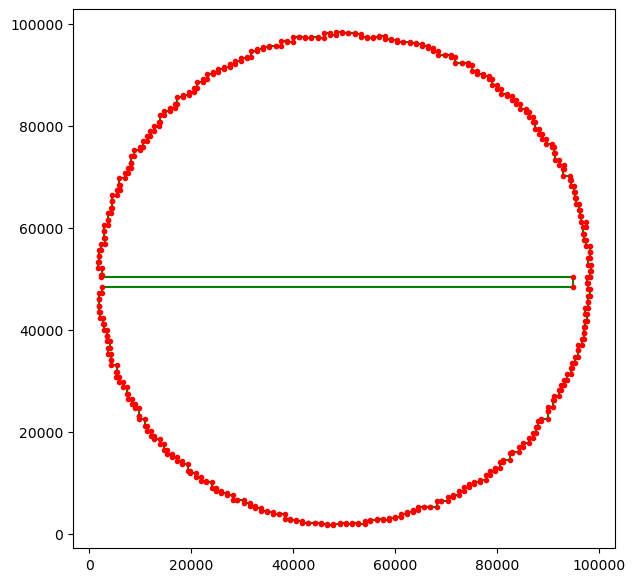

In [62]:
def plot_tiles(red_tiles: Sequence[Point], figsize=(7, 7)) -> None:
    """Plot the red tiles (as dots) and the green border (as lines), but not the green interior."""
    red_tiles = red_tiles + red_tiles[:1] # Close the loop
    plt.figure(figsize=figsize) 
    plt.axis('equal')
    plt.plot(*T(red_tiles), 'g-')
    plt.plot(*T(red_tiles), 'r.')

plot_tiles(red_tiles)

**Very Interesting!** Here's what I'm thinking:
- Most of the lines of green tiles are very short, except for the two long lines across the "equator."
- A maximal-area red-and-green rectangle can't cross the two equator lines, because there are white tiles between them.
- Therefore one of the corners of the maximal rectangle has to be one of the two points on the east end of the equator lines, and the other corner has to be somewhere on the left side of the circle.
- The points are all roughly in a circle, so we're  looking for a rectangle roughly inscribed in the circle.
- A roughly correct way to check if a candidate rectangle is all red-and-green is to make sure **the rectangle contains no red tile** in its interior. If the red tile is in the middle of the rectangle, then there must be white tiles on at least one side of the red tile, and thus in the rectangle (with some caveats).
- The red tiles are serving two purposes: as potential **corners** of the maximal rectangle, and as **obstacles** that disqualify a candidate rectangle.
- To be more precise, consider the diagram below, in which the two large red circles mark the corners of a rectangle depicted with small purple squares. I have filled in the green tiles that connect the red tiles to form a polygon, and used light green for the interior of the polygon.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img src="tiles2025.png" width=300>

- Does the purple rectangle contain only red and green tiles? Let's consider red tiles that are potential obstacles:
    - The two **corners** are obviously **ok**; they define the rectangle and they're red.
    - The two red tiles **on the border** at the bottom right are **ok**; they don't let a white square in.
    - The two red tiles that **extend one square in** to the rectangle at the top middle are **ok**; they don't let a white square in.
    - The two red tiles that are **adjacent** to each other the left side are **ok**, even though they extend three squares in, because there is no room for any white squares to fit between them. This only applies when the two adjacent tiles form a 180° U-turn like this.
    -  The red tile that **extends two squares in** from the lower right corner **disqualifies** the rectangle; it lets in the three white squares in the lower right corner.
- Besides red tile obstacles inside the rectangle, we also have to worry about two red tiles that are both outside the rectangle, but whose connecting green line passes through the interior of the rectangle. But if we assume that the largest rectangle has width and height of at least *d* spaces, then we can lay down an additional obstacle every *d* spaces, and that means there will always be an obstacle inside the rectangle. I call such obstacles "breadcrumbs." 
- If there were more red tiles we could put them into a data structure like a [quadtree](https://en.wikipedia.org/wiki/Quadtree).
- Normally in problems like this we have to check if the rectangle we are considering is inside the polygon or outside of it. But for polygons that are anything like mine (i.e., mostly convex), and if we are only considering rectangles with corners on tiles, any sufficiently large rectangle must be on the inside, so I didn't bother checking.

I'm ready to start coding! I'll start with some functions that manipulate the sequence of red tiles: finding obstacles, laying down breadcrumbs, finding adjacent tiles, and finding the 2 corners on the equator.

In [63]:
GAP = 10000 # How big a gap between red tiles to put in a "breadcrumb" red tile

def find_obstacles(red_tiles: Sequence[Point], d:int=GAP) -> Set[Point]:
    """Obstacles are tiles that, when found inside a rectangle, disqualify that rectangle.
    They are the set of red tiles with breadcrumbs added, minus the adjacent tiles with 180° turns."""
    return (set(red_tiles) | set(breadcrumbs(red_tiles, d))) - adjacent_180_tiles(red_tiles)
    
def breadcrumbs(red_tiles: Sequence[Point], d:int=GAP) -> Iterator[Point]:
    """Extra obstacles to lay down along the trail when the gap between red tiles is too big."""
    for (p, q) in sliding_window(red_tiles, 2):
        if distance(p, q) > d: 
            dx, dy = d * sign(X_(p) - X_(q)), d * sign(Y_(p) - Y_(q))
            for i in range(1, distance(p, q) // d + 1):
                yield (X_(q) + i * dx, Y_(q) + i * dy)

def adjacent_180_tiles(red_tiles: Set[Point]) -> Set[Point]:
    """Yield all adjacent points that form a 180 degree U-turn."""
    return union({q, r} for (p, q, r, s) in sliding_window(red_tiles, 4)
                 if distance(q, r) == 1 and direction(p, q) == direction(s, r))

def find_2_corners(red_tiles, d:int=GAP) -> Optional[List[Point]]:
    """Find two adjacent corners, separated on each side by a gap of at least `d`."""
    return first([q, r] for [p, q, r, s] in sliding_window(red_tiles, 4)
                 if distance(p, q) > d and distance(r, s) > d)

def direction(p: Point, q: Point) -> Point:
    """A unit vector in the orthogonal direction from p to q."""
    ((x1, y1), (x2, y2)) = p, q
    return (sign(x2 - x1), sign(y2 - y1))

Let's visualize the breadcrumbs (blue squares) and the two corners (black diamonds):

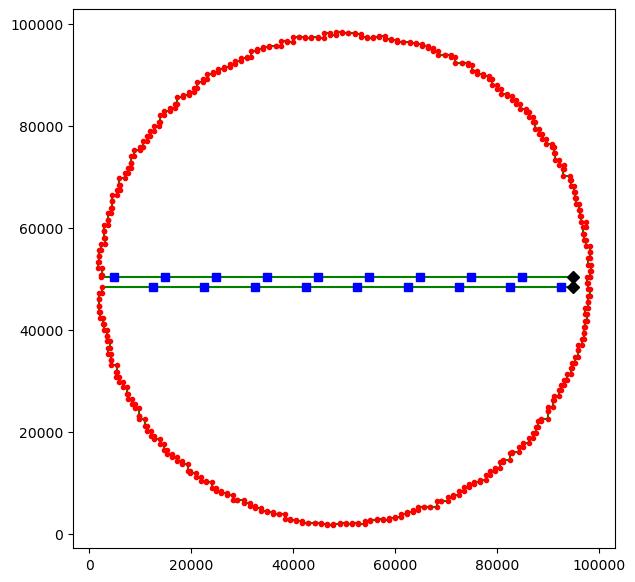

In [64]:
plot_tiles(red_tiles)
plt.plot(*T(breadcrumbs(red_tiles)), 'bs');
plt.plot(*T(find_2_corners(red_tiles)), 'kD');

Now I'll define `biggest_rectangle` to find the maximal-area all-red-and-green rectangle. I'll do that by considering pairs of corner points, where the first corner can be any red tile, and by default the second corner can also be any red tile, but you can optionally pass in the result of `find_2_corners` to speed things up. We then sort the possible rectangles by area, biggest first, and go through them one at a time. When we find one that does not have `any_intrusions`, we return it; it must be the biggest. 

The function `any_intrusions` checks to see if a red tile is completely inside the rectangle defined by the corners, by checking the x and y coordinates of each red tile against the bounds of the rectangle.

In [65]:
def biggest_rectangle(red_tiles, second_corners=None, d:int=GAP) -> Rectangle:
    """Find the biggest rectangle that stays within the interior-and-border of the red tiles.
    You can pass in a hint for `second_corners`, or they can default to `red_tiles`."""
    obstacles = find_obstacles(red_tiles, d)
    rectangles = cross_product(second_corners or red_tiles, red_tiles)
    for rect in sorted(rectangles, key=tile_area, reverse=True):
        if not any_intrusions(obstacles, rect):
            return rect
    raise ValueError('No rectangle') # Shouldn't get here unless there are no corners

def any_intrusions(obstacles: List[Point], rect: Rectangle) -> bool:
    """Does any ostacle point intrude inside the rectangle?"""
    # OK for an obstacle to be on border or just one square in, but not 2 squares in
    xlo, xhi = min(Xs(rect)) + 2, max(Xs(rect)) - 2
    ylo, yhi = min(Ys(rect)) + 2, max(Ys(rect)) - 2
    return any(xlo <= x <= xhi and ylo <= y <= yhi
               for (x, y) in obstacles)

We're ready to solve the puzzle:

In [66]:
answer(9.2, 1529675217, lambda:
       tile_area(biggest_rectangle(red_tiles, find_2_corners(red_tiles))))

Puzzle  9.2:   .0068 seconds, answer 1529675217      correct

Let's see what the biggest rectangle looks like (at a bigger scale to see more detail):

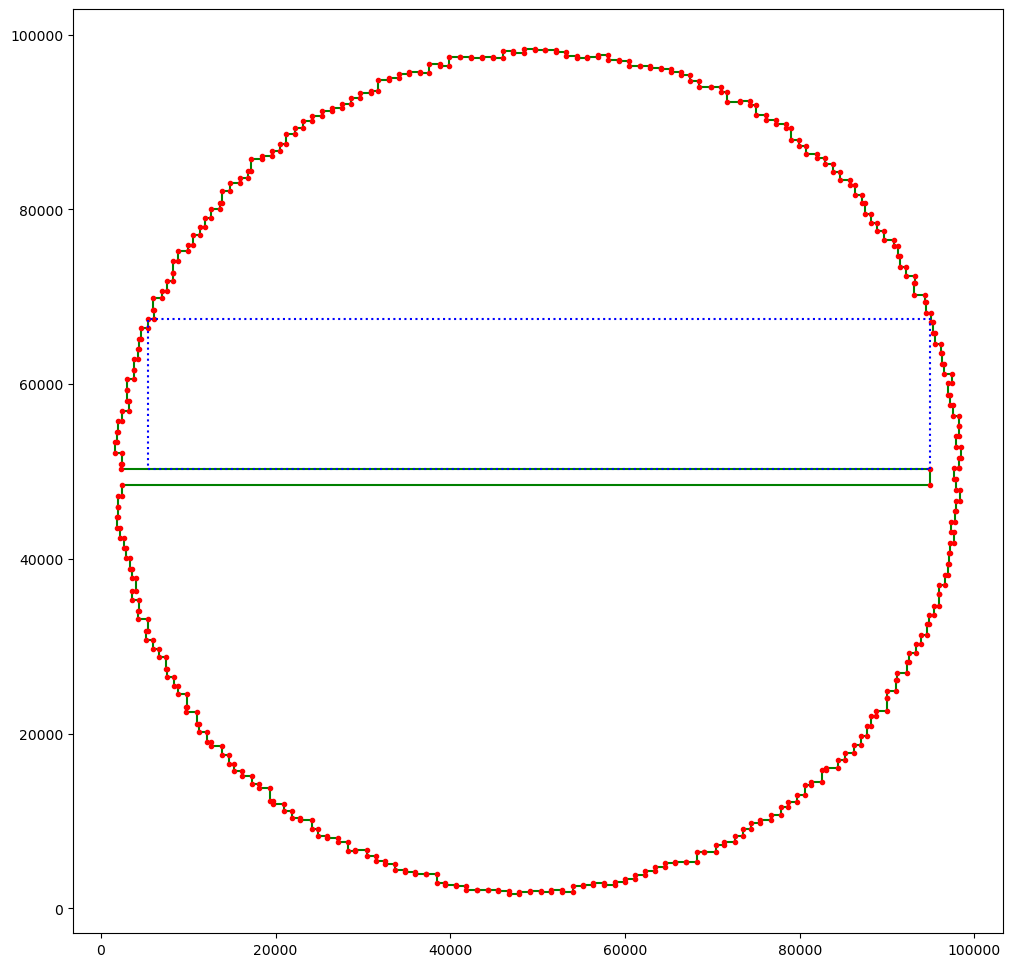

In [67]:
def plot_rect(rect: Rectangle, fmt='b:') -> None:
    """Plot a rectangle."""
    ((x1, y1), (x2, y2)) = rect
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], fmt)
    
plot_tiles(red_tiles, figsize=(12, 12))
plot_rect(biggest_rectangle(red_tiles, find_2_corners(red_tiles)))

We see that if the upper-left corner of the blue rectangle were any higher, then there would be red (and white) tiles in the upper-right corner of the rectangle. If the upper-left corner of the blue rectangle were any further southwest that would be ok, but would result in a slightly smaller area. You'll just have to take it for granted that all the possible rectangles formed below the equater lines are also a little bit smaller in area.

What if we didn't rely on the second corner being an equatorial point? Would the answer be the same? Would it be a lot slower? Let's  check:

In [68]:
%time tile_area(biggest_rectangle(red_tiles, red_tiles)) == tile_area(biggest_rectangle(red_tiles, find_2_corners(red_tiles)))

CPU times: user 1.3 s, sys: 139 ms, total: 1.44 s
Wall time: 547 ms


True

Yes, it gets the correct answer, and yes, it is slower.

In my puzzle (and if Eric Wastl is being fair (which he always is), then in everybody's puzzle) there were no adjacent points, and thus no `adjacent_180_tiles`. So here is a test case with five pairs of adjacent points. We can see that `adjacent_180_tiles` coorectly found the ten adjacent points (the magenta "o"s), that it correctly did not eliminate obstacles for the adjacent points that do not form 180° U-turns, and that `biggest_rectangle` finds what appears to be the right answer.

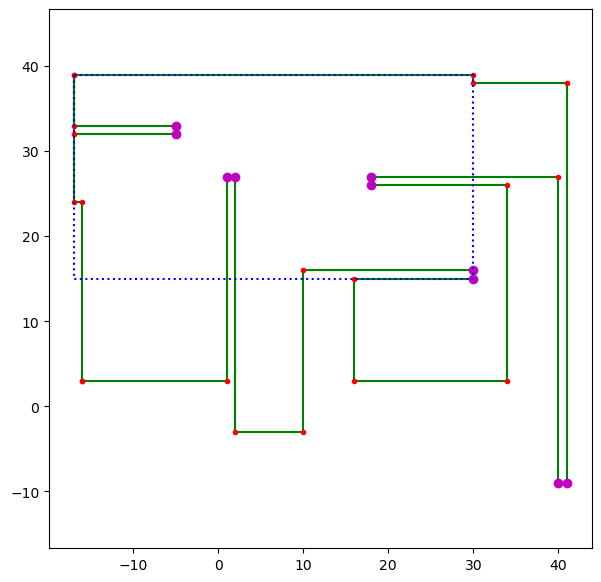

In [69]:
points = [(-16, 3), (-16, 24), (-17, 24), (-17, 39), (-17, 32), (-5, 32), (-5, 33), (-17, 33), 
          (-17, 39), (30, 39), (30, 38), (41, 38), (41, -9), 
          (40, -9), (40, 27), (18, 27), (18, 26), (34, 26), (34, 3), (16, 3), (16, 15), 
          (30, 15), (30, 16), (10, 16), (10, -3), (2, -3), (2, 27), (1, 27), (1, 3)]

plot_tiles(points)                             # Green dots and red lines
plt.plot(*T(adjacent_180_tiles(points)), 'mo') # The eliminated obstacles are magenta dots
plot_rect(biggest_rectangle(points))           # Rectangle is blue dotted line

**Three final remarks**:
1) This was the first puzzle of the year that was **difficult**; we had to work to find an efficient solution.
2) My solution is **unsatisfying** in that it works for *my* input, and I strongly suspect that it would work for *your* input, because Eric Wastl probably created them all to be similar. But it does not work on every possible input (particularly a highly non-convex shape).
3) In retrospect, I could have done the standard edge-edge intersection algorithm for determining if the rectangle intersects the polygon formed by the red tiles. I was scared away from that because the geometry is tricky for general polygon intersection, when the edges can have any slope. But the geometry is actually easy when all lines are axis-aligned.

# [Day 10](https://adventofcode.com/2025/day/10): Factory

Today we find the machines in the factory are offline. Each machine has some lights, some buttons that can be pressed, and a joltage requirement for each light. For example, the machine described by:

    [.##.] (3) (1,3) (2) (2,3) (0,2) (0,1) {3,5,4,7}

has four lights, and the goal configuration `.##.` means that the second and third light should be on and the others off. There are six buttons (each delimited by parentheses): the first button toggles light number 3, the second toggles lights 1 and 3, and so on. (The machine uses 0-based indexing, so light number 3 is the fourth light.) Finally, the joltage requirements for the four lights are `3,5,4,7`. We can parse the input lines into machine descriptions like this:

In [70]:
def parse_machine(line: str) -> tuple:
    """Parse a line into lights, buttons, joltage."""
    lights, *buttons, joltage = line.split()
    return lights[1:-1], mapt(ints, buttons), ints(joltage) 
    
machines = parse(10, parse_machine)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 165 strs of size 30 to 209:
────────────────────────────────────────────────────────────────────────────────────────────────────
[.##....#..] (0,1,3,4,5,6,7,8,9) (0,1,2,4,5,6,7,8,9) (0,1,2,4,6,7,9) (1,2,3,5,7,8,9) (1,3,8) (7) ...
[..#.....#] (0,2,4,6,7) (0,4,6,7) (0,1,2,5,7,8) (0,3,5,8) (0,1,2,3,4,7,8) (3,5,7) (3,6) (0,1,2,3 ...
[.#....###] (4,7) (2,6,7,8) (0,1,2,4,6,7,8) (0,5) (5,8) (1,4,5) (0,2,3,5,6) (2,4,5,8) (2,3) (0,6 ...
[.###.##.##] (1,3,4,6,7,8) (0,1,2,4,8) (1,2,5,6,8,9) (3) (0,2,4,8) (1,4,5,6) (2,4,6,8,9) (0,1,3, ...
[#.##..###.] (2,3,5,7,8) (4,5) (0,1,2,4,5,7) (2,6,7) (2,3,4,5,6,7,8,9) (0,3,5,6,8,9) (0,1,2,3,5, ...
[#....] (0,2,3) (0,2,3,4) (2,3) (0,1,2) (0,3,4) (3) (1,2) {75,18,60,71,39}
[##.##..] (1,2,3,4,6) (2,4) (0,1,3,5) (0,2,3,5) (0,1,3,4) {14,25,30,34,25,10,20}
[...#.#] (0) (1,4) (3,5) (2,4) (0,1,2,3) (1,2) (0,1,2,4) {50,56,62,34,48,17}
...
─────────────

<img src="https://files.mastodon.social/media_attachments/files/115/697/749/838/363/398/original/ddbf352ead43705a.jpg" width=500>

### Part 1: What is the fewest button presses to configure the lights on all the machines?

The lights are initially all off, and we want to get them to the goal configuration with the minimum number of button presses. It makes no sense to press any button twice; that just toggles lights on and off and we end up where we started. So we want to find the smallest subset of buttons that when pressed gives the goal light configuration. The function `powerset` (from the [itertools recipes](https://docs.python.org/3/library/itertools.html#itertools-recipes)) yields subsets in smallest first order, so just look for the first subset of the buttons that toggles every light the proper odd/even number of times. 

In [71]:
def minimal_button_presses(machine) -> int:
    """How many button presses to configure lights on this machine?
    First try all ways of pressing 1 button, then all ways of pressing 2 buttons, ...
    Return as soon as one way matches the goal configuration of lights."""
    lights, buttons, joltage = machine
    goal = [".#".index(ch) for ch in lights] # i.e., lights = ".##." ⇒ goal = (0, 1, 1, 0)
    for pressed in powerset(buttons):
        # Check that total presses for each light mod 2 is equal to goal for that light
        presses = Counter(flatten(pressed))
        if all(presses[light] % 2 == on_or_off for (light, on_or_off) in enumerate(goal)):
            return len(pressed)
    return inf # Couldn't solve; return infinity

In [72]:
answer(10.1, 441, lambda:
       sum(map(minimal_button_presses, machines)))

Puzzle 10.1:   .0840 seconds, answer 441             correct

### Part 2: What is the fewest button presses to configure the joltage levels on all the machines?

In Part 2 we move a lever, and now the function of the buttons changes: they control the joltage levels of the lights, not the lights themselves. The joltage levels all start at zero. Pressing the button `(2, 3)` increments the joltage level of lights numbered 2 and 3 by one unit each. Our task is to get the joltage levels all exactly to the target levels in the minimum number of presses.

My first thought when reading the puzzle description was "*This is an [**integer linear programming**](https://en.wikipedia.org/wiki/Integer_programming) problem.*" My thought was confirmed by the instructions that said "*You have to push each button an integer number of times; there's no such thing as 0.5 presses (nor can you push a button a negative number of times),*" because having fractional or negative results is exactly what you might get from linear programming (you have to take extra steps to constrain the results to be non-negative and to be integers).

Still, I was reluctant to use an integer linear programming package; that would mean that someone else is writing most of the code. This could also be seen as a search problem; I started programming an A* search solution, but it was way too slow. Why is it slow? Let's investigate. First, the number of buttons per machine is not too bad:

In [73]:
mean(len(buttons) for (_, buttons, _) in machines)

7.181818181818182

The showstopper is the expected number of button presses per machine (total joltage requirements divided by average joltage added by each button press):

In [74]:
mean(sum(joltage) / mean(map(len, buttons)) for (_, buttons, joltage) in machines)

114.81498043610085

That means a completely naive search would have to consider about 7<sup>115</sup> possible button press sequences. Of course we can take advantage of the structure of the problem to make some optimizations to the search:
1) Many joltage states will be repeated; we can cache them.
2) Button presses are commutative; we can impose a canonical ordering.
3) We can keep track of the best solution found so far and eliminate states that can't reach the goal in that number of presses.
4) Some actions will be forced: if there is only one button that increments a given light, we *must* press it until the light hits its goal.
5) If there are only two buttons that increment a given light, then the total presses of those two buttons must equal the joltage requirement for that light.
6) And if there are three buttons that increment a given light, maybe we can somehow eliminate one button to get to two, and then to one.
7) Come to think of it, that process of button elimination already has a name: [Gaussian elimination](https://en.wikipedia.org/wiki/Gaussian_elimination). Reluctantly, I will give in to the power of linear programming.

A linear programming solver finds a solution **x** to the equation **A** **x** = **b** that minimizes the dot product **c** · **x**, where **A** is a two-dimensional matrix and the other variables are one-dimensional vectors.

For our problem we have:
- **b** is the vector of joltage requirements for each light,
- **c** says how much it costs to press each button, which is one press each so **c** is a vector of all ones,
- **A** is a matrix where **A**<sub>*i,j*</sub> says how much button *j* increments joltage *i* (either 0 or 1),
- **x** will be the solution returned by the solver: a vector of number-of-pushes for each button.





I started researching integer programming packages that run in Python. [Z3](https://github.com/Z3Prover/z3) seems to be the most popular, but it is a separate step to install it. I know that I (and many other people) already have **scipy** installed, and the [**scipy.optimize**](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) package contains the function [**milp**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.milp.html#scipy.optimize.milp), for "mixed integer linear programming."  The "mixed" part means that we can declare that some of the variables must be integers, while others can be continuous. (For our problem they will all be integers.)

The arguments to **milp** are:
- **c**: the cost vector (a 1 for every button in our problem),
- **integrality**: indicates which variables must be integers (a 1 (True) for every button in our problem),
- **constraints**: a linear constraint. I want to say **A** **x** = **b**, but in this package I have to say  **lb** ≤ **A** **x** ≤ **ub**, where **lb** and **ub** are the lower and upper bounds on **b**. In our problem both **lb** and **ub** are the joltage requirements.

If we give it the right inputs, **milp** will magically return a minimal-cost result for **x**. Here's how we get the data out of a `machine` and feed it to **milp**:

In [75]:
from scipy.optimize import milp, LinearConstraint, Bounds
import numpy as np

def minimal_joltage_presses(machine) -> int:
    """The minimal number of button presses to set the joltages on this machine."""
    lights, buttons, joltage = machine
    A = T([[int(i in button) for i in range(len(lights))]
           for button in buttons])
    ones = [1] * len(buttons)
    result = milp(c=ones, 
                  integrality=ones,
                  constraints=LinearConstraint(A, lb=joltage, ub=joltage))
    return round(sum(result.x))

I made a few mistakes in not understanding the parameters of **milp**, but eventually I got it right and I was absolutely ***amazed*** at the speed:

In [76]:
answer(10.2, 18559, lambda:
       sum(map(minimal_joltage_presses, machines)))

Puzzle 10.2:   .1304 seconds, answer 18559           correct

**This felt like cheating!** I only wrote a few lines of code, and **milp** did the rest. My main contribution was just recognizing that this was an integer programming problem.

At least I can do a bit of analysis. One thing I was interested in: a system of linear equations can be determined, underdetermined, or overdetermined:
- **Determined**: Same number of equations as variables (same number of buttons as lights); one unique solution.
- **Underdetermined**: Fewer equations than variables (fewer buttons than lights); usually multiple solutions; we want the minimal one.
- **Overdetermined**: More equations than variables (more buttons than lights); no exact solutions unless you are lucky (but for this puzzle Eric Wastl can make sure we are lucky every time).

How under- or over-determined are the equations for our machines?

In [77]:
Counter(sign(len(lights) - len(buttons)) for (lights, buttons, joltage) in machines)

Counter({-1: 68, 1: 65, 0: 32})

This says that 32 machines are determined, 68 are underdetermined and 65 are overdetermined. By how much?

In [78]:
Counter(len(lights) - len(buttons) for (lights, buttons, joltage) in machines)

Counter({-1: 32, -2: 31, 1: 34, 2: 31, 0: 32, -3: 5})

Most by only 1 or two variables, but `(-3, 5)` means that 5 of the machines are underdetermined by 3 variables. Most of the time taken by **milp** must have been in searching for a minimal solution to these underdetermined cases.

Here are some tests on smaller machines that I used when I was unsure where my mistakes with **milp** were:

In [79]:
machine1 = parse_machine('[.##.] (3) (1,3) (2) (2,3) (0,2) (0,1) {3,5,4,7}')
machine2 = parse_machine('[...#.] (0,2,3,4) (2,3) (0,4) (0,1,2) (1,2,3,4) {7,5,12,7,2}')

assert 2 == minimal_button_presses(machine1)
assert 3 == minimal_button_presses(machine2)

assert 10 == minimal_joltage_presses(machine1)
assert 12 == minimal_joltage_presses(machine2)

# [Day 11](https://adventofcode.com/2025/day/11): Reactor

There are a bunch of servers here in the reactor room. Today's input consists of a list of device connectivity specifications; the line "`wfc: ond mpw vsz`" means that device `wfc` outputs to 3 devices, `ond`, `mpw`, and `vsz`. I'll capture the data like this:

In [80]:
devices = parse(11, atoms)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 643 strs of size 8 to 104:
────────────────────────────────────────────────────────────────────────────────────────────────────
wfc: ond mpw vsz
qxn: mow khk
nzf: rti sqv
ehm: von pgy fxk
nlt: pdl hwf
xqa: qvc cih
ghq: ren
jze: gbj
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 643 tuples of size 2 to 26:
────────────────────────────────────────────────────────────────────────────────────────────────────
('wfc', 'ond', 'mpw', 'vsz')
('qxn', 'mow', 'khk')
('nzf', 'rti', 'sqv')
('ehm', 'von', 'pgy', 'fxk')
('nlt', 'pdl', 'hwf')
('xqa', 'qvc', 'cih')
('ghq', 'ren')
('jze', 'gbj')
...


### Part 1: How many different paths lead from you to out?

We are asked how many distinct output paths there are from the device named `'you'` to the device named `'out'`. It is a simple recursive count, but I'll make two optimizations:
- I'll convert the list of devices into a `dict`, for *O*(1) lookup instead of *O*(*n*).
- It is likely that multiple paths will lead to the same intermediate devices, so I should memoize the counting function. (Note that a `dict` is not hashable and thus can't be in a `@cache`, so I make an inner function, `count`, and decorate that.)

In [81]:
def count_paths(devices, start='you', end='out'):
    """How many distinct paths are there from start to end?"""
    lookup_table = {device: outputs for (device, *outputs) in devices}
    @cache
    def count(here, there) -> int:
        if here == there:
            return 1
        else:
            return sum(count(mid, there) for mid in lookup_table[here])
    return count(start, end)

All very straightforward.

In [82]:
answer(11.1, 574, lambda:
       count_paths(devices))

Puzzle 11.1:   .0003 seconds, answer 574             correct

### Part 2: How many paths from svr to out visit both dac and fft?

Now we are asked for a count of the paths from a different start device, `svr`, to the end device `out`, but the paths are constrained to visit some other devices along the way. That's easy; copy the structure from Part 1, but keep track of what other devices we still need to visit:

In [83]:
def count_constrained_paths(devices, start='svr', end='out', others=frozenset({'dac', 'fft'})):
    """How many distinct paths are there from start to end, visiting all the others?"""
    lookup_table = {device: outputs for (device, *outputs) in devices}
    @cache
    def count(here, there, others) -> int:
        others -= {here}
        if here == there:
            return (1 if not others else 0)
        else:
            return sum(count(mid, there, others) for mid in lookup_table[here])
    return count(start, end, others)

In [84]:
answer(11.2, 306594217920240, lambda:
       count_constrained_paths(devices))

Puzzle 11.2:   .0020 seconds, answer 306594217920240 correct

# [Day 12](https://adventofcode.com/2025/day/12): Christmas Tree Farm 

On the twelfth day, we're in a cavern full of Christmas trees and the elves would like help arranging presents under the trees. The day's input is in two sections. The first section is a list of 6 present shapes, each annotated with their shape ID. Every present shape fits in a 3x3 grid, but they are odd shapes so some shapes  could be squished closer together. The second section is a list of regions, where each region has a width and length, and a desired number of presents of each shape to fit, in shape-ID order. Each shape is a separate paragraph, but the regions are all in on paragraph, so I can parse them like this:

In [85]:
def parse_presents(text: str):
    """Parse either a single present (e.g. "5: ###...") or list of regions (e.g. "12x5: 1 0 1 0 2 2\n...")."""
    if 'x' in text:
        return tuple((W, L, quantities) for (W, L, *quantities) in map(ints, text.splitlines()))
    else:
        id, *shape = text.splitlines()
        return (int(id[:-1]), shape)
    
*shapes, regions = parse(12, parse_presents, paragraphs, show=33)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 1030 strs of size 0 to 24:
────────────────────────────────────────────────────────────────────────────────────────────────────
0:
###
.##
##.

1:
##.
##.
###

2:
#..
##.
###

3:
###
#.#
#.#

4:
#.#
###
#.#

5:
##.
.##
..#

45x41: 52 43 45 41 47 59
45x41: 29 27 34 34 34 36
41x37: 44 34 38 35 40 44
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 7 tuples of size 2 to 1000:
────────────────────────────────────────────────────────────────────────────────────────────────────
(0, ['###', '.##', '##.'])
(1, ['##.', '##.', '###'])
(2, ['#..', '##.', '###'])
(3, ['###', '#.#', '#.#'])
(4, ['#.#', '###', '#.#'])
(5, ['##.', '.##', '..#'])
((45, 41, [52, 43, 45, 41, 47, 59]), (45, 41, [29, 27, 34, 34, 34, 36]), (41, 37, [44, 34, 38, 3 ...


### Part 1: How many of the regions can fit all of the presents listed?

There have been Tetris-like puzzles in past AoC years. Is this another search problem? If so, how big will the search trees be? I want to get a feel. First, how many regions?

In [86]:
len(regions)

1000

What's the average area of the regions?

In [87]:
mean(W * L for (W, L, _) in regions)

1822.223

And average total quantity of presents in a region?

In [88]:
mean(sum(quantities) for (_, _, quantities) in regions)

240.488

Next I want to get a feel for the variation in how tight the packing is. Each present can definitely fit into a 3x3 **box**, so what's the ratio of the total quantity of presents to the number of 3x3 boxes? I'll make a histogram of that ratio, which I'll call the occupancy ratio, for each region:

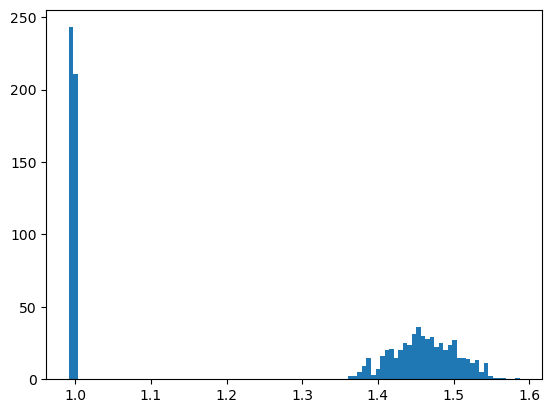

In [89]:
def boxes(region_W, region_L, shape_W=3, shape_L=3) -> int: 
    """Number of shape-sized boxes that can fit into a WxL region. By default 3x3 boxes."""
    # Our presents all fit in a 3x3 box, but if they were diffferent, say 4x3,
    # then we try to fit the boxes into the region both ways and take the most.
    return max((region_W // shape_W) * (region_L // shape_L),
               (region_W // shape_L) * (region_L // shape_W))
    
occupancy_ratios = [sum(quantities) / boxes(W, L) 
                    for (W, L, quantities) in regions]

plt.hist(occupancy_ratios, bins=100);

**Very interesting!** There's a real split. About half the regions have an occupancy ratio below 1.0 and thus are trivially easy to fit into the region: just plop one present into each 3x3 box, without worrying about rotations. The rest of the regions with occupancy ratios above 1.35 may well be impossible to fit. Just looking at the shapes, I estimate that the average overlap of one shape with another would be to save two "." squares; so I could see getting to an occupancy rato of 1 + 2/9 = 1.22, but I don't think it is possible to get to 1.35; almost certainly not 1.4 or more. I can prove it is impossible to fit all the presents in a region if the total area of the solid parts of the presents (the '#' squares) is more than the total area of the region (the width times length). 

I can do **triage** on the regions to classify each one as a trivial fit, an impossible fit, or an uncertain fit (for which we would have to do a search):

In [90]:
def triage(regions, shapes) -> str:
    """Decide if a region's presents trivially fit, or are impossible to fit, or it is uncertain."""
    shape_area = [cat(shape).count('#') for shape in shapes] # List of total number of '#' in each shape
    counts = Counter()
    for (width, length, quantities) in regions:
        presents_area = sum(q * shape_area[i] for (i, q) in enumerate(quantities))
        result = ('fit'  if sum(quantities) <= boxes(width, length) # The presents all fit in their own 3x3 box
             else 'fail' if presents_area > width * length          # The presents are bigger than the region
             else '????')                                           # Uncertain; would need a search
        counts[result] += 1
    return counts

Here goes:

In [91]:
triage(regions, shapes)

Counter({'fail': 546, 'fit': 454})

**There are no uncertain regions!** The problem is solved, and I didn't have to rotate a single present! Sometimes the real treasure is the code you don't have to write along the way.

In [92]:
answer(12.1, 454, lambda:
       triage(regions, shapes)['fit'])

Puzzle 12.1:   .0021 seconds, answer 454             correct

# Summary

Here are the run times and the correct answers for each of the puzzles:

In [93]:
summary(answers)

Puzzle  1.1:   .0006 seconds, answer 1182            correct
Puzzle  1.2:   .0013 seconds, answer 6907            correct
Puzzle  2.1:   .0039 seconds, answer 23560874270     correct
Puzzle  2.2:   .0039 seconds, answer 44143124633     correct
Puzzle  3.1:   .0007 seconds, answer 17085           correct
Puzzle  3.2:   .0020 seconds, answer 169408143086082 correct
Puzzle  4.1:   .0610 seconds, answer 1569            correct
Puzzle  4.2:   .1437 seconds, answer 9280            correct
Puzzle  5.1:   .0118 seconds, answer 635             correct
Puzzle  5.2:   .0002 seconds, answer 369761800782619 correct
Puzzle  6.1:   .0021 seconds, answer 5877594983578   correct
Puzzle  6.2:   .0061 seconds, answer 11159825706149  correct
Puzzle  7.1:   .0011 seconds, answer 1681            correct
Puzzle  7.2:   .0020 seconds, answer 422102272495018 correct
Puzzle  8.1:   .6053 seconds, answer 24360           correct
Puzzle  8.2:   .6392 seconds, answer 2185817796      correct
Puzzle  9.1:   .0262 sec

I solved all the puzzles and they run in under 2 seconds of total run time. 

Happy Advent everyone, and thank you [Eric Wastl](https://was.tl/) for the interesting puzzles!

<p></p>

<p></p>

<img src="https://files.mastodon.social/media_attachments/files/115/708/315/279/158/735/original/77b18cf6b3fba015.jpg" width=500 alt="Gary Grady cartoon">
And thank you <a href="https://mastodon.social/@garygrady">Gary Grady @GaryGrady</a> for the drawings!
